In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.python.ops.parallel_for.gradients import jacobian
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]

In [3]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [4]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [5]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                                                          zoom_range=0.1)
datagen.fit(x_train.reshape((50000,28,28,1)))

In [6]:
tf.reset_default_graph()

batch_size = 256
hidden_size = 8

def inference(in_net):
    with tf.variable_scope('generator/inference', reuse=tf.AUTO_REUSE):
        net = tf.layers.dense(in_net, 512, name='dense_1', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 384, name='dense_2', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 256, name='dense_3', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 2*hidden_size, name='dense_5', activation=None)
    return net

def generator(in_net):
    with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):
        net = tf.layers.dense(in_net, 256, name='dense_1', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 384, name='dense_2', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 512, name='dense_3', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 784, name='dense_5', activation=None)
    return net

lr = tf.placeholder_with_default(0.001,shape=[])


x = tf.placeholder(shape=[batch_size, 784], dtype=tf.float32)

prior = tfd.MultivariateNormalDiag(tf.zeros(hidden_size), scale_identity_multiplier=1.0)

mu, sigma = tf.split(inference(x), 2, axis=-1)
sigma = tf.nn.softplus(sigma) + 0.0001
approx_posterior = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

z = approx_posterior.sample()

x_sims = tfd.Independent(tfd.Bernoulli(logits=generator( prior.sample(batch_size)))).sample()

data_likelihood = tfd.Independent(tfd.Bernoulli(logits=generator(z)))

kl_divergence = tfd.kl_divergence(approx_posterior, prior)

elbo = - tf.reduce_mean(data_likelihood.log_prob(x) - kl_divergence,axis=0)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead',

In [7]:
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
opt_op = optimizer.minimize(elbo)

Instructions for updating:
Use tf.cast instead.


In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [9]:
losses_data = []

In [12]:
nepochs=10
for ep in range(nepochs):
    gen = datagen.flow(x_train.reshape((50000,28,28,1)), batch_size=batch_size)
    count = 0
    print('new epoch')
    
    for i in range(50000 // batch_size):
        # Train the inference model
        imgs = next(gen)
        
        if len(imgs) < batch_size:
            imgs = next(gen)
            
        imgs = imgs.reshape([-1,784])

        # Train the generative model
        _, l  = sess.run([opt_op, elbo], feed_dict={x: imgs, lr:0.0001})
        
        losses_data.append(l)
        
        count += 1
        if count % 10 ==0:
            print(ep, l)

new epoch
0 138.338
0 145.76773
0 138.39452
0 141.09161
0 136.7981
0 139.03304
0 143.00424
0 141.47139
0 136.13565
0 141.6409
0 135.97696
0 135.4232
0 140.0227
0 137.23616
0 138.33585
0 132.42953
0 139.46765
0 136.88782
0 141.17673
new epoch
1 139.7061
1 143.47528
1 138.77765
1 134.21167
1 132.96355
1 139.33057
1 139.21854
1 139.87004
1 139.81857
1 134.68144
1 140.0083
1 141.01288
1 138.73788


KeyboardInterrupt: 

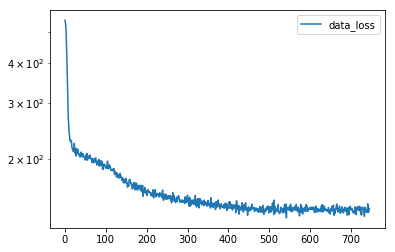

In [16]:
plot(losses_data,label='data_loss')
legend()
yscale('log')

In [17]:
res = sess.run(z, feed_dict={x: x_test[0:batch_size]})
labels = targets_test[0:batch_size]

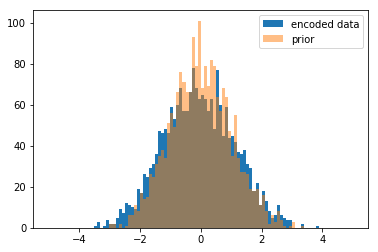

In [18]:
hist(res.flatten(),100,range=[-5,5],label='encoded data');
hist(randn(len(res.flatten())),100,range=[-5,5],alpha=0.5,label='prior');
legend()

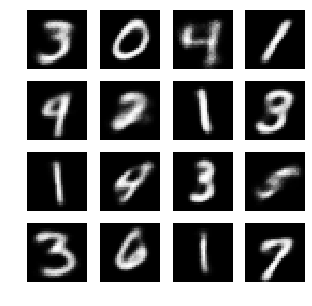

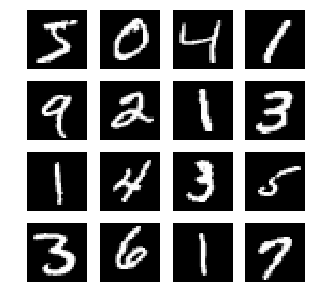

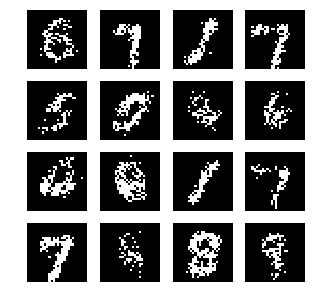

In [24]:
res, inim, s = sess.run([data_likelihood.mean(), x, x_sims], feed_dict={x: x_train[0:batch_size]})
figure(figsize=(5,5))
for i in range(16):
    subplot(4,4,i+1)
    imshow((res )[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
figure(figsize=(5,5))
for i in range(16):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
for i in range(16):
    subplot(4,4,i+1)
    imshow(s[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')